In [1]:
import os
import keras
import numpy as np
import pandas as pd
import io
import bson
from subprocess import check_output
import multiprocessing as mp 

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import skimage

In [272]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_DIR = "/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/"

In [5]:
%pylab inline
from skimage.data import imread

Populating the interactive namespace from numpy and matplotlib


# Pre-processing bson input
[jump](#HERE)
* First we map category_id to an integer for one-hot
* Second, we pre-process the bson file so we can randomly access each image. We store the offset and length of product item info into a .csv file

In [6]:
from src.make_lookup_tables import *

In [7]:
# making category_id -> category_idx lookup table
# make_categories_df(os.path.join(DATA_DIR, "category_names.csv"))

categories_df = pd.read_csv(os.path.join(DATA_DIR, "categories.csv"), index_col=0)
categories_df.head()

,category_level1,category_level2,category_level3,level1_idx,level2_idx,category_idx,category_level1_EN,category_level2_EN
category_id,,,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0,subscription / services,prepaid card
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1,urban development - roads,urban development
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,1,1,2,urban development - roads,urban development
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,1,1,3,urban development - roads,urban development
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,1,2,4,urban development - roads,signage


In [9]:
# train_offsets_df = make_offsets_df()
train_offsets_df = pd.read_csv("/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/train_offsets.csv",
                                  index_col=0)
train_offsets_df = pd.merge(train_offsets_df, categories_df.iloc[:, [3,4,5]], how="left", left_on="category_id", right_index=True)
train_offsets_df.head()

,num_imgs,offset,length,category_id,level1_idx,level2_idx,category_idx
product_id,,,,,,,
0,1,0,6979,1000010653,45,455,5055
1,1,6979,7318,1000010653,45,455,5055
2,1,14297,5455,1000004079,22,191,2530
3,1,19752,4580,1000004141,22,199,2592
4,1,24332,6346,1000015539,10,87,1492


In [607]:
from sklearn.model_selection import train_test_split

In [10]:
train_images_df = pd.read_csv(os.path.join(DATA_DIR, "train_images.csv"), index_col=0)
val_images_df = pd.read_csv(os.path.join(DATA_DIR, "val_images.csv"), index_col=0)

In [11]:
print "Number of training products:", len(train_images_df)
print "Number of validation products:", len(val_images_df)
print "Total products:", len(train_images_df) + len(val_images_df)
print "Percentage of training products is: ", float(len(train_images_df))/(len(train_images_df) + len(val_images_df))

Number of training products: 5655916
Number of validation products: 1413980
Total products: 7069896
Percentage of training products is:  0.799999886844


# Dataset

Now we are interested in the distribution of target classes. This is an extreme classification problem, with 5270 target classes, comparing with ImageNet, having only 1000 object categories. Also, lots of the target classes are under-represented.

In [12]:
print "Number of lvl3 categories in training data: ", len(train_images_df["category_idx"].unique())
print "Number of lvl3 categories in validation data: ", len(val_images_df["category_idx"].unique())

Number of lvl3 categories in training data:  5270
Number of lvl3 categories in validation data:  5270


In [13]:
print "Number of lvl1 categories in data: ", len(categories_df.category_level1.unique())
print "Number of lvl2 categories in data: ", len(categories_df.category_level2.unique())

Number of lvl1 categories in data:  49
Number of lvl2 categories in data:  483


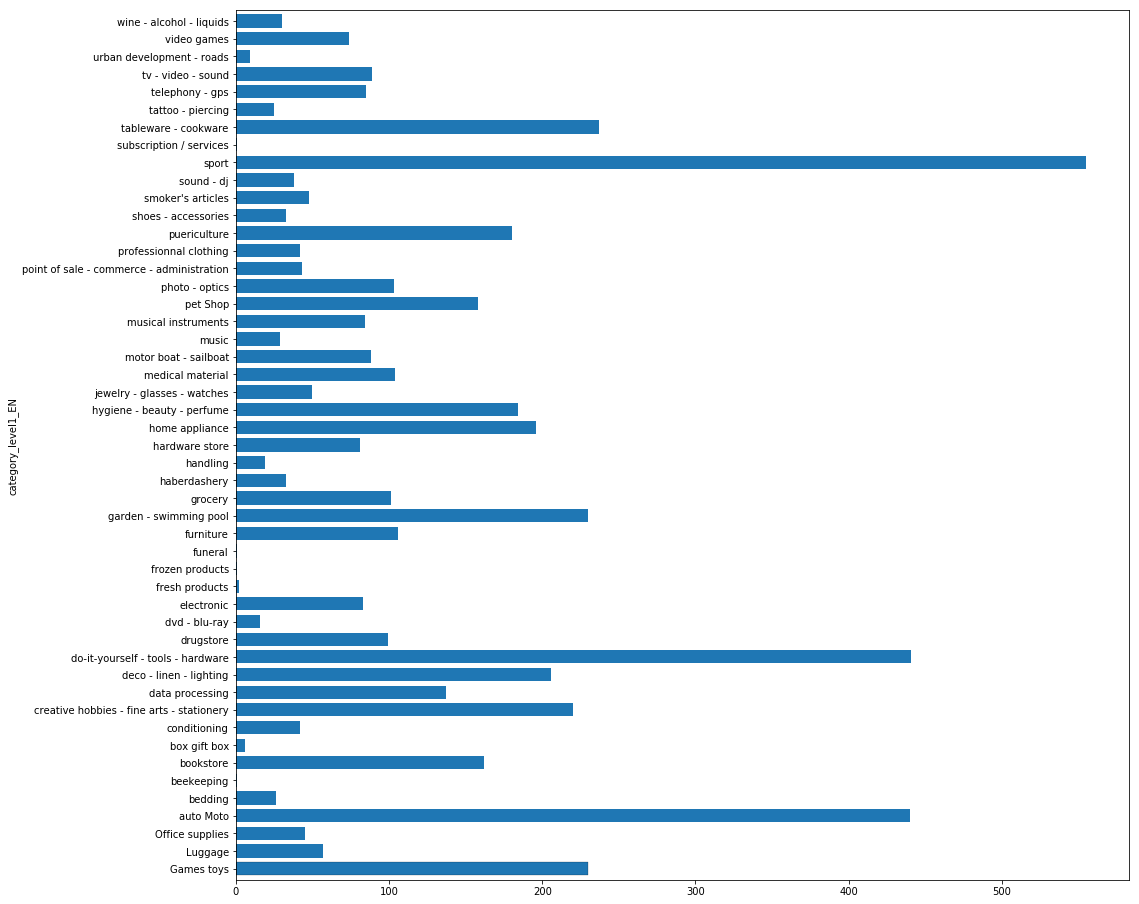

In [14]:
# plotting number of level2 categories per level1 category

figsize(16, 16)
(categories_df
.groupby("category_level1_EN")
.category_level2_EN
.value_counts()
.unstack(level=0)
.sum()
.plot(kind="barh", fontsize=10, edgecolor='k', linewidth=0.2, legend=False, width=0.75))

In [16]:
from src.util import *

lvl2 category is:  tattoo ink


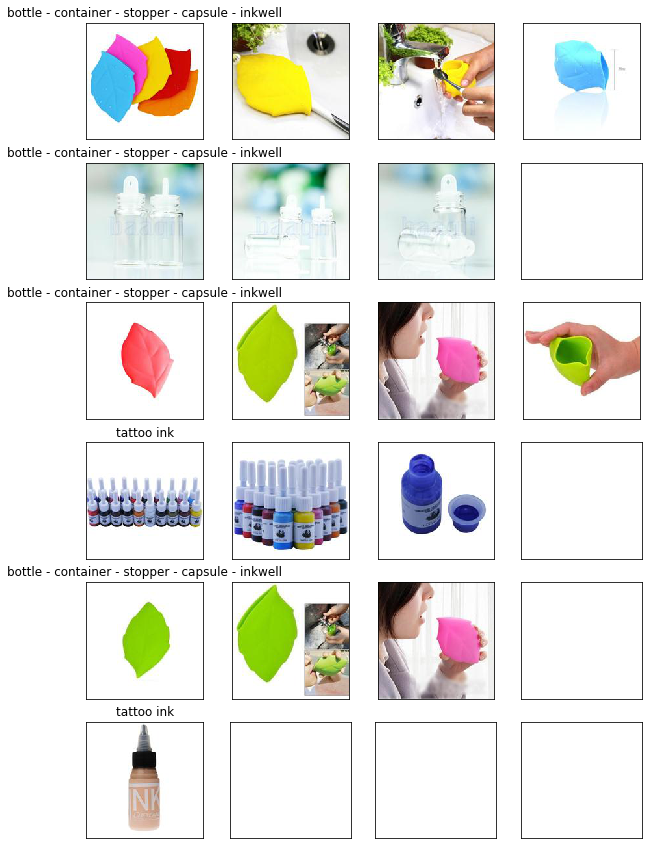

In [19]:
lvl2_str = np.random.choice(categories_df.category_level2.unique())

num_items = 6
fig, axes = subplots(num_items, 4)
fig.set_size_inches(2.5 * 4, 2.5*num_items)

print "lvl2 category is: ", translator.translate(lvl2_str.lower(), src='fr').text
for row in range(num_items):
    pic, text = plot_lvl2_products(lvl2_str)
    axes[row, 0].set_title(text)
    for col in range(4):
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        sca(axes[row, col])
        if (col < len(pic)):
            imshow(pic[col])

lvl3 category is:  CASQUE - ECOUTEUR FILAIRE - KIT PIETON GPS
headset - wired earphone - pedestrian gps kit


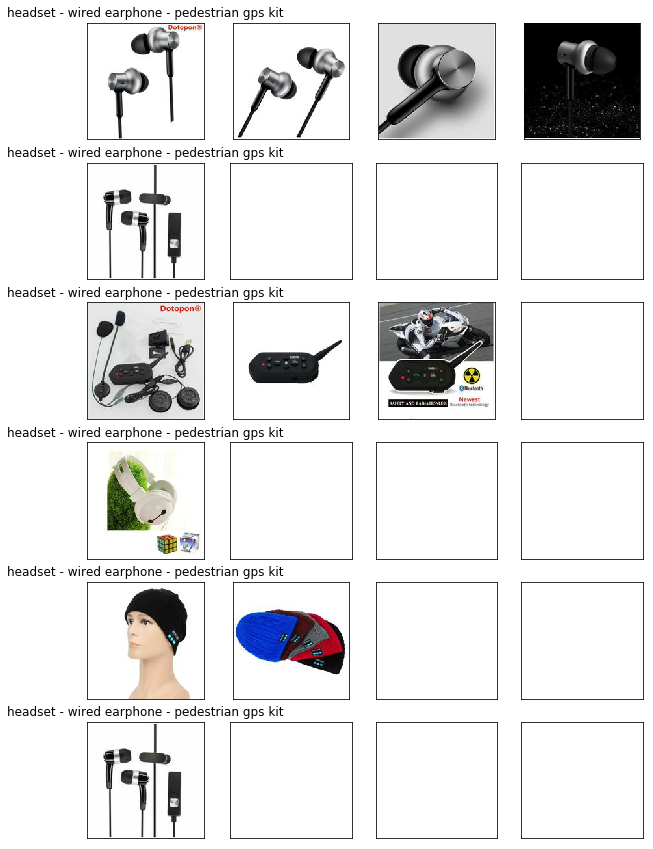

In [21]:
lvl3_str = np.random.choice(categories_df.category_level3.unique())
print "lvl3 category is: ", lvl3_str

num_items = 6
fig, axes = subplots(num_items, 4)
fig.set_size_inches(2.5 * 4, 2.5*num_items)

print translator.translate(lvl3_str.lower(), src='fr').text
for row in range(num_items):
    pic, text = plot_lvl3_products(lvl3_str)
    axes[row, 0].set_title(text)
    for col in range(4):
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        sca(axes[row, col])
        if (col < len(pic)):
            imshow(pic[col])

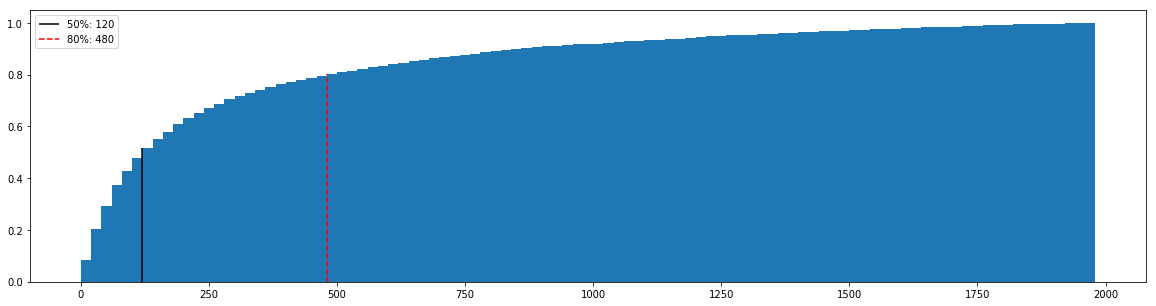

In [22]:
# plotting number of images per lvl3 group
num_samples_per_category = train_images_df.category_idx.value_counts(normalize=False)
bins = np.arange(0,2000,20)

figsize(20, 5)
out = hist(array(num_samples_per_category), bins=bins, cumulative=True, density=True);
# plot 50% 
i1 = abs(out[0]-0.5).argmin()
vlines(out[1][i1], ymin=0, ymax=out[0][i1], label='50%: '+ str(out[1][i1]) )
# plot 80%
i2 = abs(out[0]-0.8).argmin()
vlines(out[1][i2], ymin=0, ymax=out[0][i2], linestyles="dashed", colors='r', label='80%: '+ str(out[1][i2]) )
legend()

Around 50% of the classes have less than 200 images. Only 20% of the classes has more than 640 images representing them. Which means for each specific class, the number of samples is not sufficient. 

# Define Tensorflow computational graph

We decide to train a Siamese network which discriminates "same" and "different" a pair of products.

In [23]:
import tensorflow as tf
from tensorflow import data
from tensorflow.python.framework import dtypes
from src import datagenerator
from tensorflow.contrib.data import Iterator

In [204]:
train_file_path = os.path.join(DATA_DIR, "train_images.csv")
val_file_path = os.path.join(DATA_DIR, "val_images.csv")
batch_size = 10

In [205]:
from collections import defaultdict

In [234]:
OUT_DIM = 224
IMG_DIM = 180
IMG_CHNL = 3

In [250]:
[tf.squeeze(s, [1]) for s in tf.split(X1, num_or_size_splits=4, axis=1)]

[<tf.Tensor 'Squeeze:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'Squeeze_1:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'Squeeze_2:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'Squeeze_3:0' shape=(?, 224, 224, 3) dtype=float32>]

In [276]:
from src.model import CNN_SiameseNet

In [277]:
model = CNN_SiameseNet(left, right, trainable=True)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [271]:
tf.reset_default_graph()

with tf.device("/cpu:0"):
    tr_data = datagenerator.ImageDataGenerator(sample_file_path=train_file_path, 
                                               shuffle=True, 
                                               is_training=True,
                                               batch_size=batch_size)
    val_data = datagenerator.ImageDataGenerator(sample_file_path=val_file_path,
                                                shuffle=True,
                                                is_training=False,
                                                batch_size=batch_size)
    
    # create an reinitializable iterator given the dataset structure  
    iterator = Iterator.from_structure(tr_data.data.output_types,
                                       tr_data.data.output_shapes)
    next_batch = iterator.get_next()

    training_init_op = iterator.make_initializer(tr_data.data)
    validation_init_op = iterator.make_initializer(val_data.data)
    
    # graph input
    left, right, Y, left_labels, right_labels = next_batch
    left.set_shape([None, 4, OUT_DIM, OUT_DIM, IMG_CHNL])
    right.set_shape([None, 4, OUT_DIM, OUT_DIM, IMG_CHNL])
    Y.set_shape([None, 1])
    
    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    
    # Initialize model
    model = CNN_SiameseNet(left, right, trainable=True)
    # model.siamese_twins(left, right, train_mode=True, reuse=True)
    

Using saved weight:/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/temp/vgg16_weights.npz


AttributeError: 'CNN_SiameseNet' object has no attribute 'siamese_twins'

In [252]:
SAVE_DIR = r"/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/temp"
weight_path = os.path.join(SAVE_DIR, "vgg16_weights.npz")

In [231]:
sess = tf.InteractiveSession()

# Initialize an iterator over a dataset with 10 elements.
sess.run(training_init_op)
# sess.run(validation_init_op)
batch = sess.run(Y)

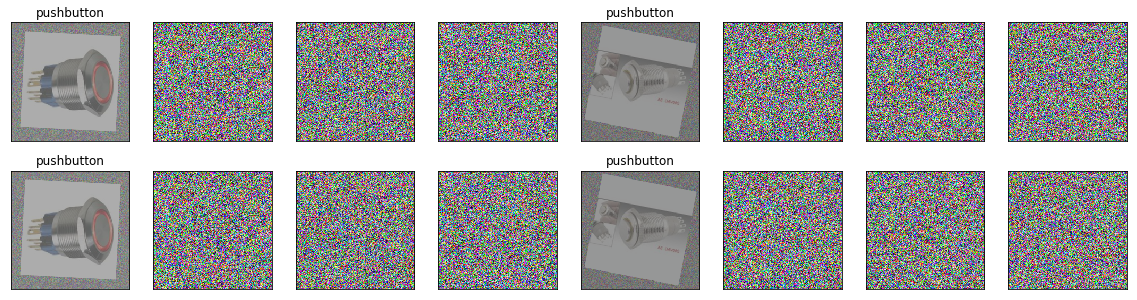

In [229]:
visualize_batch(batch, display_num=2)